# Bear Detector with Histogram of Oriented Gradients and Scikit-Learn

In [1]:
from skimage import data, color, feature
import skimage.data
import matplotlib.pyplot as plt
from PIL import Image
import glob
import numpy as np
from itertools import chain
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from imgaug import augmenters as iaa

%matplotlib inline

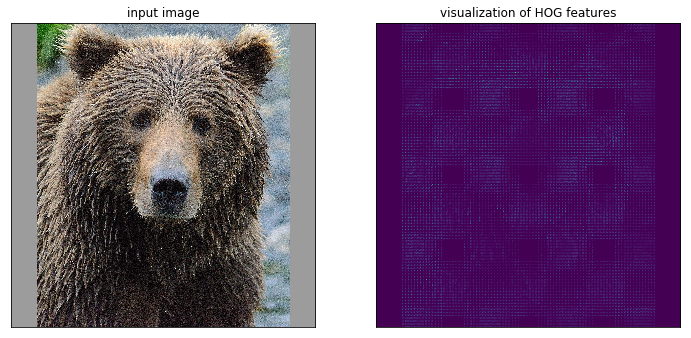

In [2]:
image = color.rgb2gray(data.chelsea())

image = plt.imread('../../data/bears_pad/5.jpg')

hog_vec, hog_vis = feature.hog(image, visualise=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

In [3]:
data_array = []

# Get image files
img_files = glob.glob('../../data/bears_pad/*.*')

for img in img_files:
    im = Image.open(img)
    # Resize to uniform size
    im = im.resize((64, 64))
    # Convert to grayscale
    im = im.convert('L')
    im = np.asarray(im)
    data_array.append(im)

# Convert collection to numpy array
positive_patches = np.asarray(data_array)
positive_patches.shape

(49, 64, 64)

In [4]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [5]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 2, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(60, 64, 64)

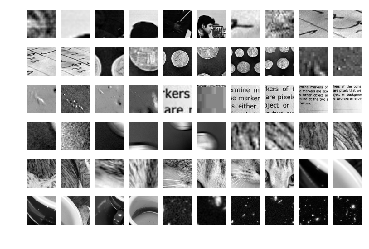

In [6]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[i], cmap='gray')
    axi.axis('off')

In [7]:
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1
X_train.shape


(109, 2916)

In [8]:
cross_val_score(GaussianNB(), X_train, y_train)

array([1.        , 1.        , 0.91666667])

In [9]:
grid = GridSearchCV(LinearSVC(), {'C': [0.1, 0.5, 1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.9357798165137615

In [10]:
print(grid.best_params_)
# Assign model object to best performing model from grid search
model = grid.best_estimator_

{'C': 0.1}


In [11]:
test_image = plt.imread('../../data/bears/test_bear2.jpg')
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)


In [12]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

print(test_image.shape)

scale = 1.0
indices, patches = zip(*sliding_window(test_image, scale=scale))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(166, 250)


(4743, 2916)

In [13]:
labels = model.predict(patches_hog)
labels.sum()

86.0

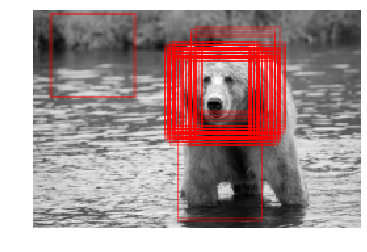

In [14]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = (positive_patches[0].shape[0] * scale), int(positive_patches[0].shape[1] * scale)
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

## Image augmentation and retrain

In [15]:
seq = iaa.Sequential([
    iaa.Fliplr(1.0), # horizontally flip all of the images
#     iaa.GaussianBlur(sigma=(0, 1.0)), # blur images with a sigma of 0 to 3.0
    iaa.ContrastNormalization((0.8, 1.2), per_channel=0.5)
])

images_aug = seq.augment_images(positive_patches)

In [16]:
images_aug.shape

(49, 64, 64)

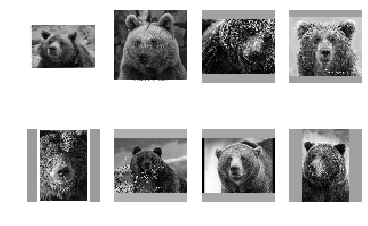

In [17]:
fig, ax = plt.subplots(2, 4)
for i, axi in enumerate(ax.flat):
    axi.imshow(positive_patches[i], cmap='gray')
    axi.axis('off')

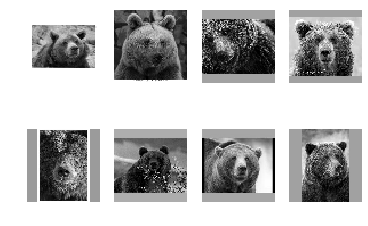

In [18]:
fig, ax = plt.subplots(2, 4)
for i, axi in enumerate(ax.flat):
    axi.imshow(images_aug[i], cmap='gray')
    axi.axis('off')

In [19]:
positive_patches_aug = np.concatenate((positive_patches, images_aug), axis=0)
positive_patches_aug.shape

(98, 64, 64)

In [20]:
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches_aug,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches_aug.shape[0]] = 1
X_train.shape

grid = GridSearchCV(LinearSVC(), {'C': [0.1, 0.5, 1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)
# Assign model object to best performing model from grid search
model = grid.best_estimator_

0.9556962025316456
{'C': 0.1}


In [21]:
# Use test image again to predict with new model
labels = model.predict(patches_hog)
labels.sum()

169.0

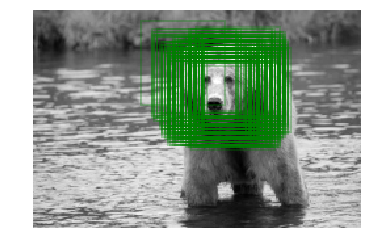

In [22]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = (positive_patches[0].shape[0] * scale), int(positive_patches[0].shape[1] * scale)
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='green',
                               alpha=0.3, lw=2, facecolor='none'))